## Data Prep for CNN

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import statistics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [149]:
path = "/Users/nicolasoederlin/code/jhupiterz/SafeSeizure/data/dataset/sensor0"

In [150]:
batch_size = 32
img_height = 96
img_width = 96

In [151]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 2 classes.
Using 103 files for training.


In [152]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 2 classes.
Using 25 files for validation.


In [153]:
class_names = train_ds.class_names
print(class_names)

['interictal_images', 'preictal_images']


In [154]:
class_weight = {0: 1.,
                1: 10}

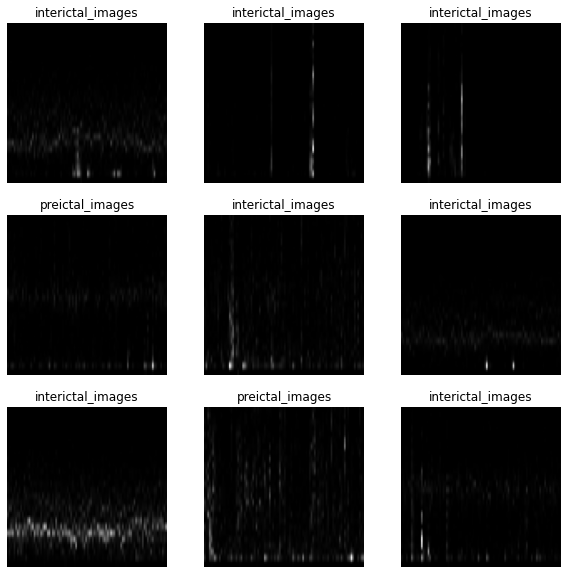

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalization 
pixels values are now in `[0,1]`

In [156]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.7958217


## Model 1 test

In [170]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Flatten(),
  layers.Dense(16, activation='softmax'),
])

In [171]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [172]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_23 (Rescaling)     (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 96, 96, 8)         224       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 48, 48, 16)        1168      
_________________________________________________________________
flatten_20 (Flatten)         (None, 36864)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                589840    
Total params: 591,232
Trainable params: 591,232
Non-trainable params: 0
_______________________________________________

In [173]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight
  
)

Epoch 1/10
4/4 [==============================] - 1s 96ms/step - loss: 6.6127 - accuracy: 0.1248 - val_loss: 1.1454 - val_accuracy: 0.4800
Epoch 2/10
4/4 [==============================] - 0s 69ms/step - loss: 2.7955 - accuracy: 0.2815 - val_loss: 0.6873 - val_accuracy: 0.6400
Epoch 3/10
4/4 [==============================] - 0s 62ms/step - loss: 1.1271 - accuracy: 0.6115 - val_loss: 0.6071 - val_accuracy: 0.8000
Epoch 4/10
4/4 [==============================] - 0s 64ms/step - loss: 1.1640 - accuracy: 0.9089 - val_loss: 0.4335 - val_accuracy: 0.7200
Epoch 5/10
4/4 [==============================] - 0s 66ms/step - loss: 0.7844 - accuracy: 0.6082 - val_loss: 0.4945 - val_accuracy: 0.8400
Epoch 6/10
4/4 [==============================] - 0s 66ms/step - loss: 0.5967 - accuracy: 0.8136 - val_loss: 0.6960 - val_accuracy: 0.8400
Epoch 7/10
4/4 [==============================] - 0s 61ms/step - loss: 0.4306 - accuracy: 0.8805 - val_loss: 0.4998 - val_accuracy: 0.8400
Epoch 8/10
4/4 [===========

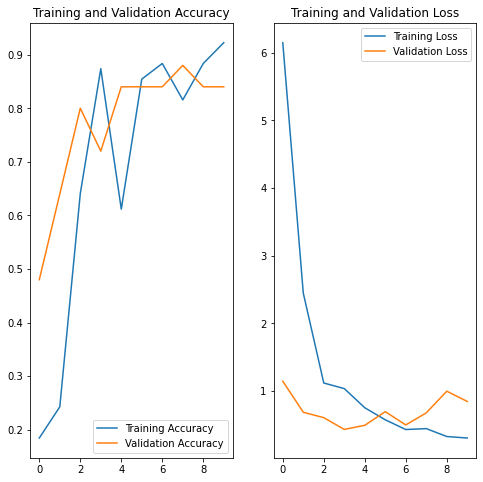

In [174]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2 test

In [114]:
model2 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (img_height,img_width,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [115]:
model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 27648)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               3539072   
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 3,539,201
Trainable params: 3,539,201
Non-trainable params: 0
_________________________________________________________________


In [116]:
model2.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [117]:
epochs=10
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 1s 65ms/step - loss: 26.9705 - accuracy: 0.6848 - val_loss: 276.5118 - val_accuracy: 0.5200
Epoch 2/10
4/4 [==============================] - 0s 49ms/step - loss: 27.2938 - accuracy: 0.8230 - val_loss: 34.4097 - val_accuracy: 0.8400
Epoch 3/10
4/4 [==============================] - 0s 45ms/step - loss: 13.7374 - accuracy: 0.8438 - val_loss: 89.0664 - val_accuracy: 0.8000
Epoch 4/10
4/4 [==============================] - 0s 43ms/step - loss: 0.1520 - accuracy: 0.9787 - val_loss: 170.8998 - val_accuracy: 0.6000
Epoch 5/10
4/4 [==============================] - 0s 43ms/step - loss: 3.9487 - accuracy: 0.9418 - val_loss: 187.3242 - val_accuracy: 0.6400
Epoch 6/10
4/4 [==============================] - 0s 46ms/step - loss: 6.1023 - accuracy: 0.9693 - val_loss: 123.2808 - val_accuracy: 0.8400
Epoch 7/10
4/4 [==============================] - 0s 42ms/step - loss: 0.0718 - accuracy: 0.9847 - val_loss: 89.4215 - val_accuracy: 0.8400
Epoch 8/10
4/

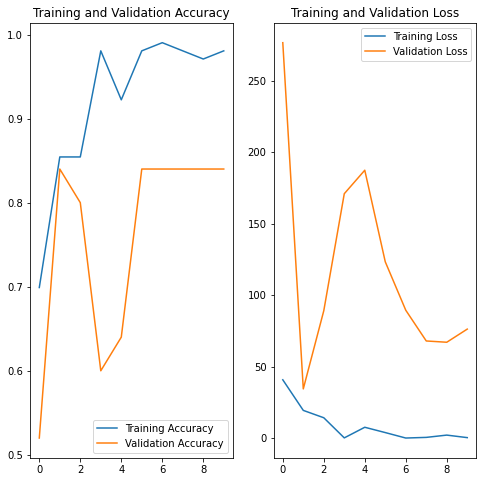

In [118]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()